# 1. Install Dependencies and Setup

In [1]:
!pip install tensorflow opencv-python matplotlib

In [2]:
!pip list

Package                       Version
----------------------------- ---------------
absl-py                       2.0.0
aiobotocore                   2.5.0
aiofiles                      22.1.0
aiohttp                       3.8.5
aioitertools                  0.7.1
aiosignal                     1.2.0
aiosqlite                     0.18.0
alabaster                     0.7.12
anaconda-anon-usage           0.4.2
anaconda-catalogs             0.2.0
anaconda-client               1.12.1
anaconda-cloud-auth           0.1.3
anaconda-navigator            2.5.0
anaconda-project              0.11.1
anyio                         3.5.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.3
astroid                       2.14.2
astropy                       5.1
asttokens                     2.0.5
astunparse                    1.6.3
async-timeout                 4.0.2
atomicwrites                  1.4.0
attrs     

In [3]:
import tensorflow as tf
import os

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [10]:
import cv2
import imghdr

In [11]:
data_dir = 'data' 

In [12]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [13]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
#             os.remove(image_path)

# 3. Load Data

In [14]:
import numpy as np
from matplotlib import pyplot as plt

In [15]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 232 files belonging to 2 classes.


In [16]:
data_iterator = data.as_numpy_iterator()

In [17]:
batch = data_iterator.next()

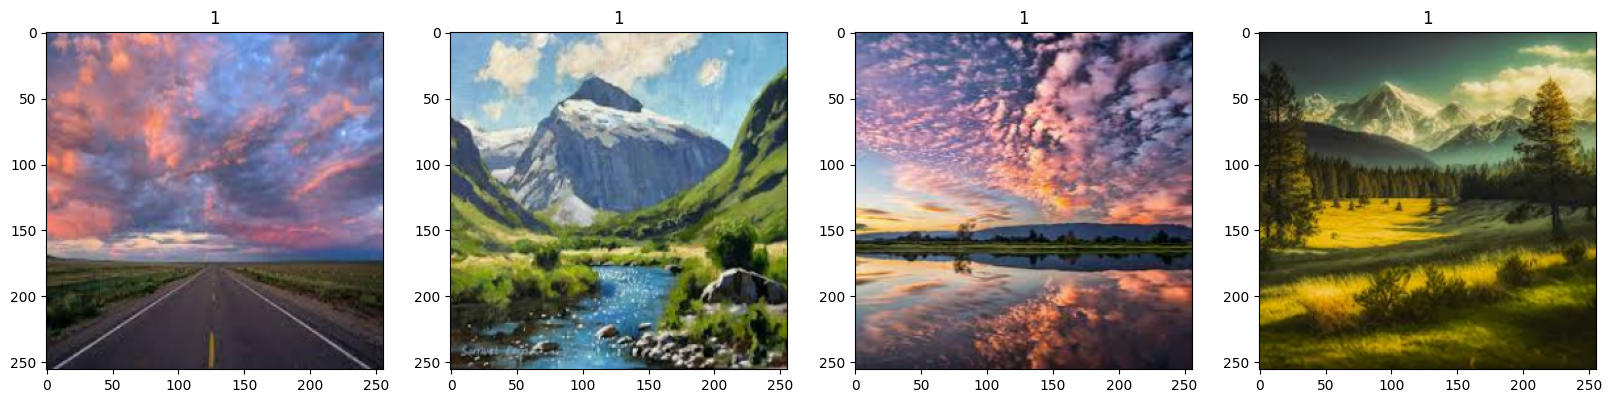

In [18]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [19]:
data = data.map(lambda x,y: (x/255, y))

In [20]:
data.as_numpy_iterator().next()

(array([[[[0.49902847, 0.63798326, 0.6850421 ],
          [0.51322067, 0.64655405, 0.68576974],
          [0.4986048 , 0.61636317, 0.6555418 ],
          ...,
          [0.4282514 , 0.44357768, 0.40709636],
          [0.69058526, 0.70234996, 0.674899  ],
          [0.77097094, 0.78806704, 0.78485036]],
 
         [[0.48392934, 0.6246783 , 0.67173713],
          [0.34539005, 0.4512724 , 0.4865665 ],
          [0.5282691 , 0.64190984, 0.6738762 ],
          ...,
          [0.29699227, 0.29699227, 0.24993347],
          [0.40699846, 0.41876316, 0.3756259 ],
          [0.64798754, 0.6561385 , 0.6268806 ]],
 
         [[0.5347245 , 0.68892825, 0.7344729 ],
          [0.52630377, 0.6825006 , 0.72221726],
          [0.56390357, 0.7487568 , 0.7921392 ],
          ...,
          [0.3191545 , 0.31523293, 0.23680156],
          [0.3196727 , 0.32751584, 0.23900075],
          [0.35109   , 0.35381553, 0.2997561 ]],
 
         ...,
 
         [[0.5819458 , 0.6464908 , 0.6641915 ],
          [0.56384

# 5. Split Data

In [21]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [22]:
train_size

5

In [23]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [24]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [26]:
model = Sequential()

In [27]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [28]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

# 7. Train

In [30]:
logdir='logs'

In [31]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [32]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10


5/5 [==============================] - 7s 776ms/step - loss: 1.3551 - accuracy: 0.5437 - val_loss: 0.6210 - val_accuracy: 0.8438
Epoch 2/10
5/5 [==============================] - 5s 749ms/step - loss: 0.5863 - accuracy: 0.7250 - val_loss: 0.4488 - val_accuracy: 0.9062
Epoch 3/10
5/5 [==============================] - 6s 816ms/step - loss: 0.4571 - accuracy: 0.8313 - val_loss: 0.3559 - val_accuracy: 0.9375
Epoch 4/10
5/5 [==============================] - 6s 961ms/step - loss: 0.3085 - accuracy: 0.9000 - val_loss: 0.2402 - val_accuracy: 0.9062
Epoch 5/10
5/5 [==============================] - 9s 1s/step - loss: 0.3123 - accuracy: 0.8562 - val_loss: 0.1587 - val_accuracy: 0.9688
Epoch 6/10
5/5 [==============================] - 8s 1s/step - loss: 0.2769 - accuracy: 0.8750 - val_loss: 0.1966 - val_accuracy: 0.9062
Epoch 7/10
5/5 [==============================] - 6s 879ms/step - loss: 0.2426 - accuracy: 0.9187 - val_loss: 0.2059 - val_accuracy: 0.9375
Epoch 8/10
5/5 [========

# 8. Plot Performance

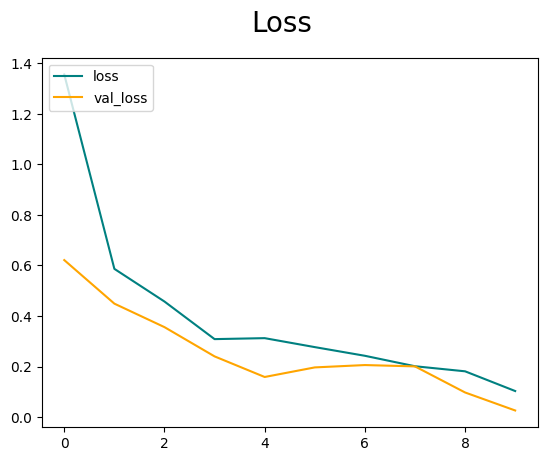

In [33]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

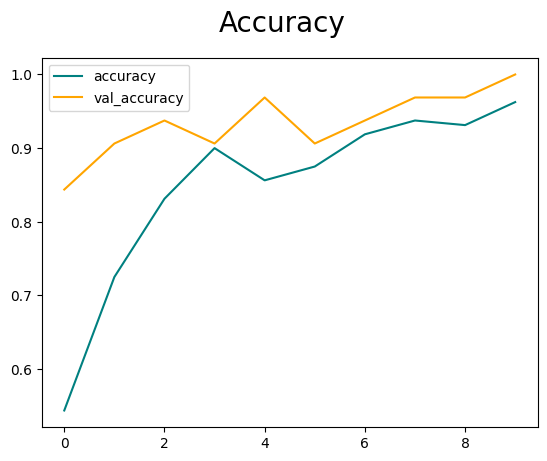

In [34]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [35]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [36]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [37]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

In [38]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)


# 10. Test

In [39]:
import cv2

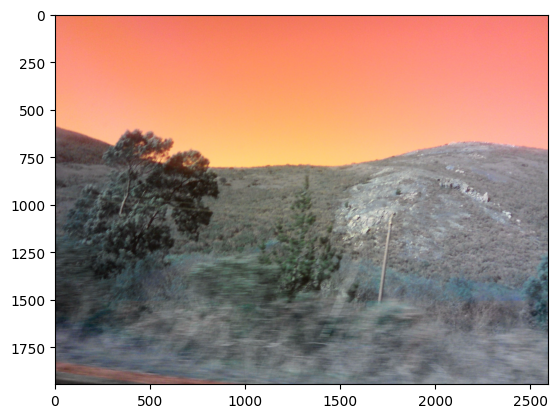

In [57]:
img = cv2.imread('IMG_20151128_115506.jpg')
plt.imshow(img)
plt.show()

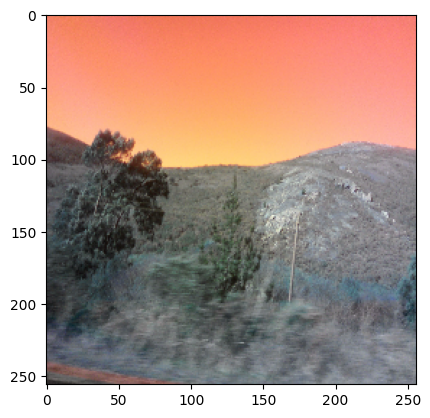

In [58]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [59]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 58ms/step


In [60]:
yhat

array([[0.7815269]], dtype=float32)

In [61]:
if yhat > 0.5: 
    print(f'Predicted class is place')
else:
    print(f'Predicted class is food')

Predicted class is place


# 11. Save the Model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model.save(os.path.join('models','imageclassifier.h5'))

In [ ]:
new_model = load_model('imageclassifier.h5')

In [ ]:
new_model.predict(np.expand_dims(resize/255, 0))